# ARIMA Modeling

> Authors: Matt Brems, Joseph Nelson, Justin Pounders

In [1]:
# !pip3 install scipy statsmodels --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
df = pd.read_csv('../data/global_land_temps.csv')

### Global Temperature Data
> We have [average temperature data](https://data.world/data-society/global-climate-change-data) for the globe from 1750 to 2015.
- `date`: the month the data was measured.
- `avg_temp`: the average global temperature (in degreed Celsius).

In [4]:
df.head()

,date,avg_temp
0,1752-10-01,7.839
1,1752-11-01,7.335
2,1752-12-01,5.086
3,1753-01-01,2.039
4,1753-02-01,0.715


In [5]:
# Set index to be the date column as a DatetimeIndex.
df.set_index(pd.to_datetime(df['date']), inplace=True)

# Drop the date column from our data.
df.drop(columns='date', inplace=True)

# Confirm.
df.head()

,avg_temp
date,
1752-10-01,7.839
1752-11-01,7.335
1752-12-01,5.086
1753-01-01,2.039
1753-02-01,0.715


Let's plot this raw data.

In [6]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

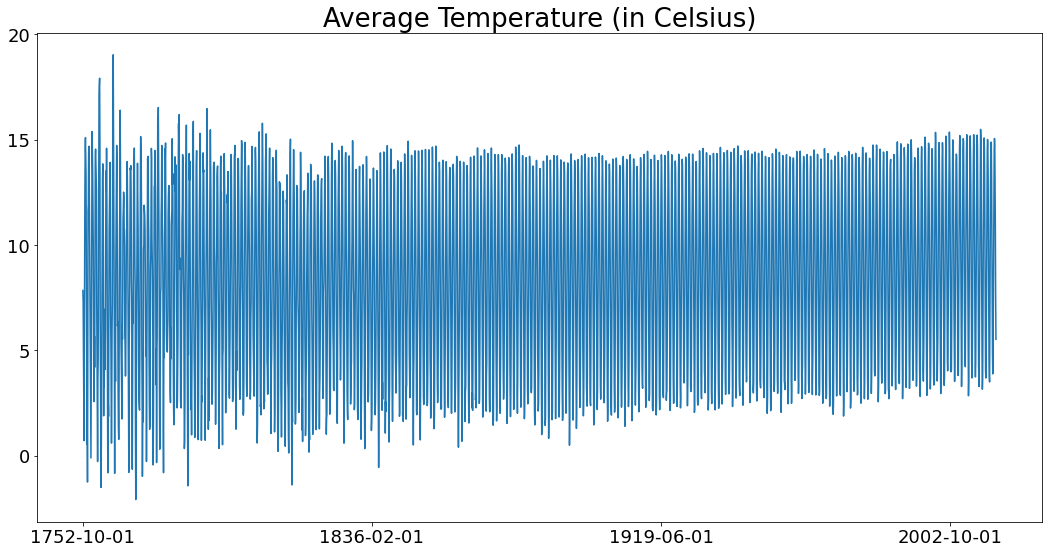

In [7]:
# Generate a time plot of our data.
plot_series(df, ['avg_temp'], title = "Average Temperature (in Celsius)", steps=1000)

<details><summary>What Pandas function may be helpful here?</summary>

- We'll use `.resample()`.
</details>

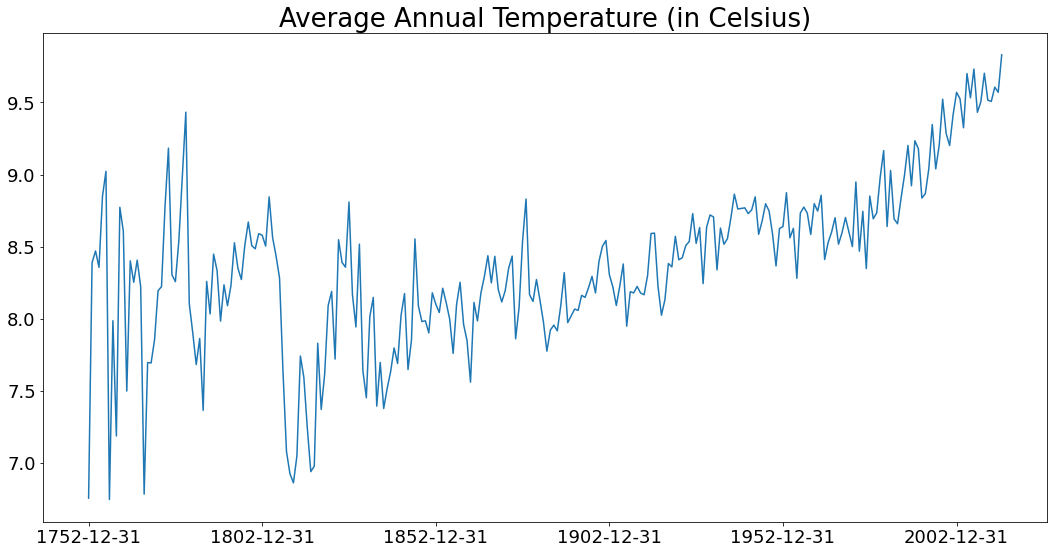

In [8]:
# Generate a time plot of our data.
plot_series(df.resample('A').mean(), cols=['avg_temp'], title='Average Annual Temperature (in Celsius)', steps=50)

In [9]:
# Overwrite df.
df = df.resample('A').mean()
df.head()

,avg_temp
date,
1752-12-31,6.753333
1753-12-31,8.388083
1754-12-31,8.469333
1755-12-31,8.355583
1756-12-31,8.849583


<details><summary>Check: How would you describe this data?</summary>
    
- **Trend**: The mean is increasing over time and it looks like it speeds up toward the end of the 1960s.
- **Seasonality**: There are fluctuations, but it's tough to see if there are fluctuations on a fixed and known frequency.
- **Autocorrelation**: The data are correlated with one another.
</details>

## ARIMA Model

In order to fit an ARIMA model, we need to specify three parameters: $p$, $d$, and $q$.
- We've already described how we'll find values of $p$ and $q$!

### Parameter $d$: How much do we difference?

$d$ is known as the **differencing parameter**. This controls how much we "difference" our time series by. _(We difference to meet an assumption - we'll talk about this in a minute!)_

Differencing our time series means that instead of fitting a model that predicts our time series $Y_t$ directly, we'll fit a model to $Y'_t$ or $Y''_t$:

$$
\begin{eqnarray*}
Y'_t &=& Y_t - Y_{t-1} \\
Y''_t &=& Y'_t - Y'_{t-1} = Y_t - 2Y_{t-1} + Y_{t-2}
\end{eqnarray*}
$$

So if I wanted to fit a model, my "new" output variable I'm trying to predict would be $Y'_t$ or $Y''_t$.

In [10]:
# Look at the first 5 values of our series.
df.head()

,avg_temp
date,
1752-12-31,6.753333
1753-12-31,8.388083
1754-12-31,8.469333
1755-12-31,8.355583
1756-12-31,8.849583


In [11]:
# Look at the first 5 values of our series, differenced once.
df.diff().head()

,avg_temp
date,
1752-12-31,NaN
1753-12-31,1.63475
1754-12-31,0.08125
1755-12-31,-0.11375
1756-12-31,0.49400


In [12]:
# Look at the first 5 values of our series, differenced twice.
df.diff().diff().head()

,avg_temp
date,
1752-12-31,NaN
1753-12-31,NaN
1754-12-31,-1.55350
1755-12-31,-0.19500
1756-12-31,0.60775


In [13]:
# Create first_diff_temp and second_diff_temp
# columns in df.
df['first_diff_temp'] = df['avg_temp'].diff()
df['second_diff_temp'] = df['avg_temp'].diff().diff()

[Why would we difference?](https://otexts.com/fpp2/stationarity.html) Well, there is one assumption that is **required** for nearly every time series model: **stationarity**.
- If our time series is stationary, then we do not need to difference and let $d=0$.
- If our time series is not stationary, then we difference either once ($d=1$) or twice ($d=2$). Differenced data often is stationary, so we difference our data, then model that!

#### What is stationarity?

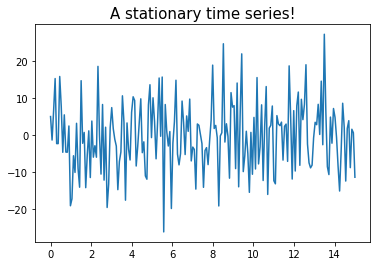

In [14]:
# Set seed.
np.random.seed(42)

# Generate 200 steps in time from 0 to 15.
t = np.linspace(0, 15, 200)

# Generate a white noise process with Normally distributed noise.
y = 5 * np.random.normal(0, 2, 200)

# Generate plot.
plt.title('A stationary time series!', fontsize=15)
plt.plot(t, y);

Informally, stationarity means that there **aren't systematic changes in our time series over time**.
- Our mean stays the same. (There is no trend.)
- The autocorrelation between $Y_t$ and $Y_{t-k}$ depends only on the size of our lag $k$. (There is no seasonality.)
- A [white noise process](https://stats.stackexchange.com/questions/7070/what-is-a-white-noise-process) is a common example of a stationary time series.

<details><summary>Is our data stationary?</summary>
    
- No! The mean is not constant over time. It looks like the mean increases over time.
- It looks like the fluctuations are more spread out in early years and get closer moving into later years.
</details>

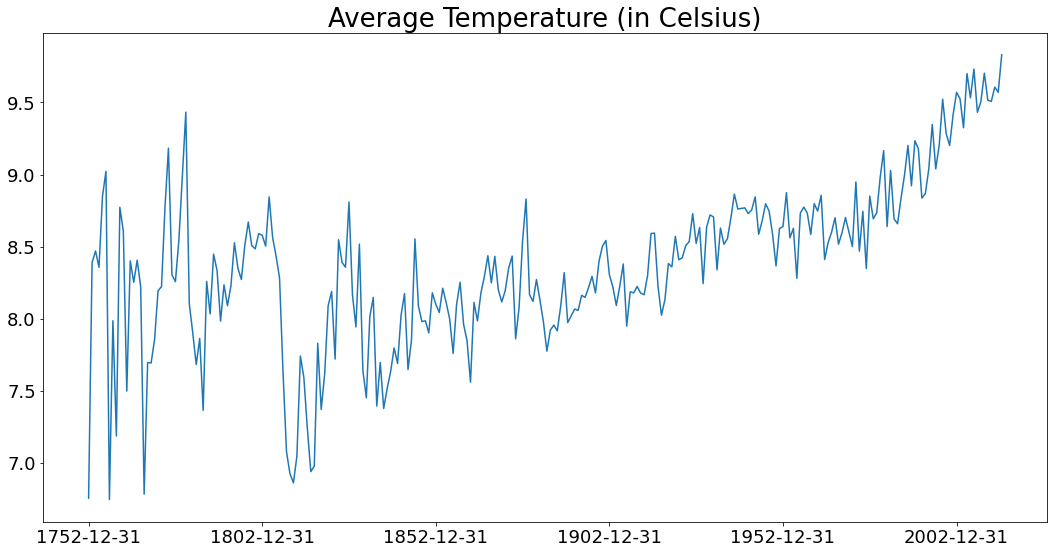

In [15]:
# Temperature data.
plot_series(df,
            ['avg_temp'],
            title = "Average Temperature (in Celsius)",
            steps = 50)

Again, why do we difference? 
- Differencing allows us to get a stationary time series out of a non-stationary time series.
- This means that we'll be able to fit an ARIMA model to the **differenced** data!

We'll start with a difference of $d = 1$ and iterate upward until we find a value of $d$ that makes our time series stationary.

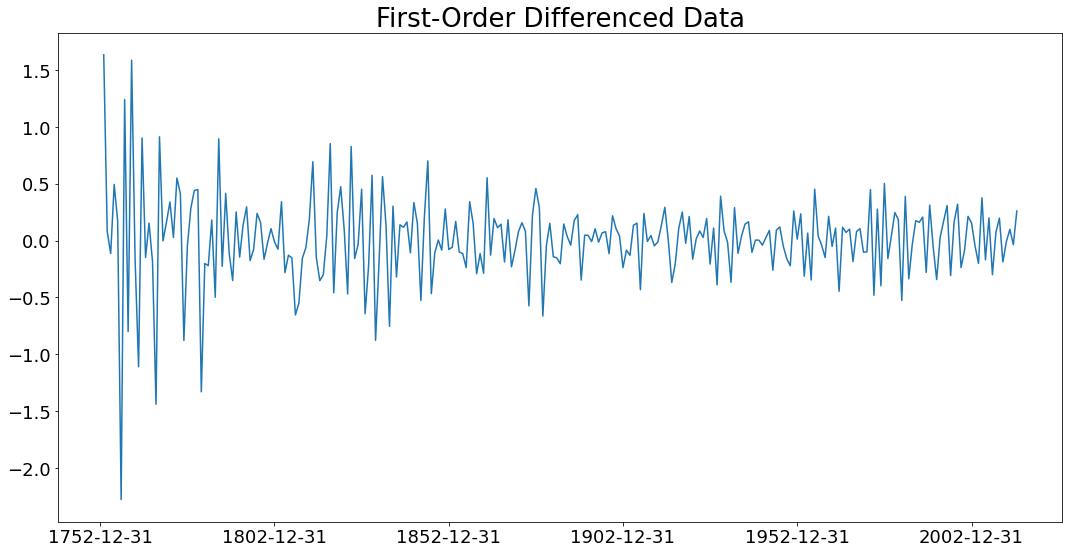

In [16]:
# Examine temperature, differenced once.

plot_series(df, ['first_diff_temp'], title = "First-Order Differenced Data", steps = 50)

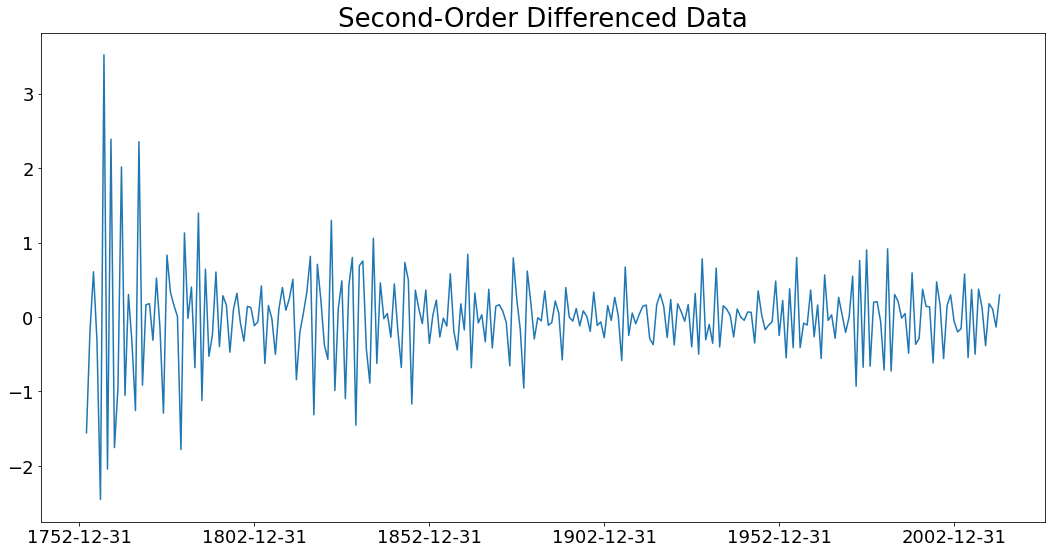

In [17]:
# Examine temperature, differenced twice.

plot_series(df, ['second_diff_temp'], title = "Second-Order Differenced Data", steps = 50)

How do we know if we let $d=1$ or $d=2$?

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

The [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

Specifically, the test is as follows:

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

<details><summary>Would a small $p$-value or a large $p$-value give us evidence that our time series is stationary?</summary>

- A small $p$-value would give us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.
</details>

In [18]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Run ADF test on original (non-differenced!) data.

adfuller(df['avg_temp'])

(-2.8627890262653537,
 0.04984939757706091,
 2,
 261,
 {'1%': -3.4556556713934934,
  '5%': -2.872678352489859,
  '10%': -2.57270548832225},
 76.34112040455113)

In [19]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [20]:
# Run ADF test on original (non-differenced!) data.

interpret_dftest(adfuller(df['avg_temp']))

Test Statistic   -2.862789
p-value           0.049849
dtype: float64

<details><summary>At alpha of 0.01, how would we interpret this $p$-value? </summary>
    
- Remember that we compare our $p$-value to $\alpha$, which is usually set at 0.10, 0.05, or 0.01. We'll use $\alpha = 0.01$. Because $p = 0.0498$, it is larger than $\alpha$. Thus, we cannot accept that our series `avg_temp` is stationary.
</details>

##### In order to achieve stationarity, we need to difference!

We'll start with a difference of $d = 1$ to see if the time series `first_diff_temp` is stationary.

In [21]:
# Run the ADF test on our once-differenced data.

interpret_dftest(adfuller(df['avg_temp'].diff().dropna()))

Test Statistic   -7.053223e+00
p-value           5.458179e-10
dtype: float64

<details><summary>Are our data, after a first-order difference, stationary?</summary>

- Yes! This is stationary.
- With a $p$-value of well below 0.05, we would reject $H_0$ and thus **accept that our first-order differenced data are stationary**.
</details>

- Rather than modeling $Y_t$ directly, we'll model $Y'_t = Y_t - Y_{t-1}$.
- If we generate plots moving forward, then we should generate plots of the **differenced** time series, not the original time series!

### Fit an ARIMA model.

There are three hyperparameters we need to get values for when fitting an ARIMA model.
1. Determine a value of $d$ using the Augmented Dickey-Fuller test.
2. Then, determine values of $p$ and $q$ through GridSearching.

An $ARIMA(p, d, q)$ model is specified by:
- how many differences $d$ we need to calculate in order to achieve stationarity.
- how many lags $p$ we regress $Y_t^{(d)}$ on.
- how many errors $q$ we regress $Y_t^{(d)}$ on.

<details><summary>Check: Recall that $AR$ incorporates information from long-term trends and $MA$ incorporates information from sudden shocks. What are some examples where we might see both long-term trends and sudden fluctuations in our time series data? </summary>

- Stock price data. Stocks increase and decrease over time, but news or other stock changes may have sudden effects on prices. (Similar logic applies to gas or oil prices.)
- Public transportation ridership. While public transportation may see slow changes over time, marketing campaigns, changes in price, or accidents may have a sudden, unforeseen shock on ridership.
- Temperature data over time!
</details>

Depending on our values of $p$, $d$, and $q$, we might refer to these models by slightly different names.

- If $d=0$ and $q=0$, an AR(p) model is specified by how many lags $p$ we regress $Y_t$ on.
- If $d=0$ and $p=0$, an MA(q) model is specified by how many errors $q$ we regress $Y_t$ on.
- If $d=0$, an ARMA(p, q) model is specified by how many lags $p$ and how many errors $q$ we regress $Y_t$ on.

| p | d | q |          Model         |
|:-:|:-:|:-:|:----------------------:|
| 1 | 0 | 0 |  ARIMA(1,0,0) = AR(1)  |
| 0 | 0 | 1 |  ARIMA(0,0,1) = MA(1)  |
| 1 | 0 | 1 | ARIMA(1,0,1) = ARMA(1,1) |
| 1 | 1 | 1 |      ARIMA(1,1,1)      |
| 1 | 1 | 0 |      ARIMA(1,1,0)      |
| 0 | 1 | 1 |      ARIMA(0,1,1)      |


In [22]:
# Create train-test split.
y_train, y_test = train_test_split(df['avg_temp'], test_size=.1, shuffle=False)

In [23]:
# Import ARIMA model.
from statsmodels.tsa.arima.model import ARIMA

## Manual GridSearch

Our strategy is this:
- Let's start AIC at some really, really big number and call it `best_aic`.
- Create variables `best_p` and `best_q` to store our best values of $p$ and $q$.
- Create a nested `for` loop to iterate over our possible values of $p$ and $q$.
    - At every combination of $p$ and $q$, fit an ARIMA model.
    - If the ARIMA model has a better (lower) AIC than `best_aic`, then let's overwrite `best_aic`, `best_p`, and `best_q` with the values of AIC, $p$, and $q$ that our better model is using!
    - If the ARIMA model has a worse (higher) AIC than `best_aic`, do nothing.
- At the end of the `for` loop, tell us which values of $p$ and $q$ give us the best model (lowest AIC).

<details><summary>What should our main concerns be about a manual GridSearch process?</summary>

- The amount of time it takes to fit our models!
- Cross-validation is also more complicated with time series data; you can check out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).
</details>

<details><summary>What is the purpose of try and except statements?</summary>

- If our code encounters an error, then it will automatically stop. Sometimes this is good (so we can debug) but sometimes this isn't desirable!
- `try` and `except` statements allow us to "try" to do something and, if there's an error, we can just `pass` it so that our code doesn't stop running.
- This isn't always a good thing... errors are usually telling us that something is wrong. But we're going to hack our answer here so that we can check all values of $p$ and $q$ and just not run the model if some values of $p$ and $q$ are invalid.
</details>

In [24]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)
The AIC for ARIMA(0,1,0) is: 243.55235863747697
Attempting ARIMA(0, 1, 1)
The AIC for ARIMA(0,1,1) is: 200.1721585695543
Attempting ARIMA(0, 1, 2)
The AIC for ARIMA(0,1,2) is: 197.96134742860832
Attempting ARIMA(0, 1, 3)
The AIC for ARIMA(0,1,3) is: 196.45744614943882
Attempting ARIMA(0, 1, 4)
The AIC for ARIMA(0,1,4) is: 194.18561935246566
Attempting ARIMA(1, 1, 0)
The AIC for ARIMA(1,1,0) is: 215.8205494940145
Attempting ARIMA(1, 1, 1)
The AIC for ARIMA(1,1,1) is: 192.08077569073515
Attempting ARIMA(1, 1, 2)
The AIC for ARIMA(1,1,2) is: 190.22988807360616
Attempting ARIMA(1, 1, 3)
The AIC for ARIMA(1,1,3) is: 192.2249881745381
Attempting ARIMA(1, 1, 4)
The AIC for ARIMA(1,1,4) is: 194.2225027067282
Attempting ARIMA(2, 1, 0)
The AIC for ARIMA(2,1,0) is: 208.92254183302128
Attempting ARIMA(2, 1, 1)
The AIC for ARIMA(2,1,1) is: 190.6547215357986
Attempting ARIMA(2, 1, 2)
The AIC for ARIMA(2,1,2) is: 194.12861046838503
Attempting ARIMA(2, 1, 3)
The AIC for ARIMA

/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(2,1,4) is: 194.2654516624864
Attempting ARIMA(3, 1, 0)
The AIC for ARIMA(3,1,0) is: 208.2432560453622
Attempting ARIMA(3, 1, 1)
The AIC for ARIMA(3,1,1) is: 192.18786862795196
Attempting ARIMA(3, 1, 2)
The AIC for ARIMA(3,1,2) is: 194.00474366565794
Attempting ARIMA(3, 1, 3)


/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,3) is: 186.68633013765196
Attempting ARIMA(3, 1, 4)


/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(3,1,4) is: 189.519727538865
Attempting ARIMA(4, 1, 0)
The AIC for ARIMA(4,1,0) is: 203.52625192602747
Attempting ARIMA(4, 1, 1)
The AIC for ARIMA(4,1,1) is: 194.12389129344263
Attempting ARIMA(4, 1, 2)
The AIC for ARIMA(4,1,2) is: 205.07764371213048
Attempting ARIMA(4, 1, 3)


/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(4,1,3) is: 189.76243676245025
Attempting ARIMA(4, 1, 4)
The AIC for ARIMA(4,1,4) is: 191.27077520078646


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,1,3).
This model has an AIC of 186.68633013765196.


/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


> Finding coefficients for an MA model is difficult, because the model requires us to regress on errors, but we don't actually observe these errors. The algorithm for fitting this is complicated and is well beyond the scope of this lesson. [Check more out here](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf). We're using `try` and `except` statements so Python errors don't cause us to stop our model-fitting process!

The model we want to fit is an $ARIMA(3,1,3)$ model. That would look like this:
$$
\begin{eqnarray*}
Y^{(1)}_t &=& AR(3) + MA(3) \\
(Y_t - Y_{t-1}) &=& \beta_0 + \beta_1(Y_{t-1} - Y_{t-2}) + \beta_2(Y_{t-2} - Y_{t-3}) + \beta_3(Y_{t-3} - Y_{t-4}) + w_1\varepsilon_{t-1} + w_2\varepsilon_{t-2} + w_3\varepsilon_{t-3} + \varepsilon_t \\
\end{eqnarray*}
$$

/Users/rileydallas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


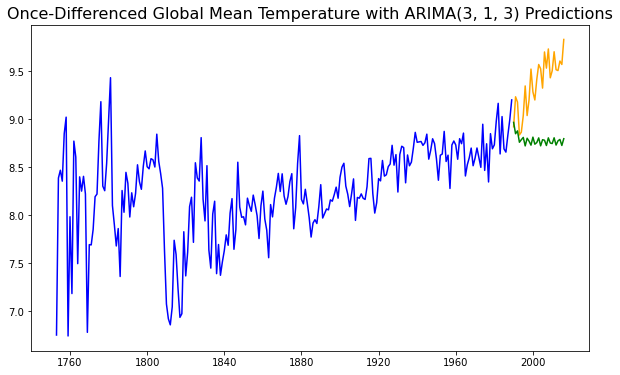

In [25]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(3, 1, 3))


# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict(start=y_test.index[0], end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Global Mean Temperature with ARIMA(3, 1, 3) Predictions', fontsize=16)
plt.show();

<details><summary>What do these predicted values represent?</summary>

- These predicted values represent $Y'_t$, which is the once-differenced mean temperature data.
- The first observation represents the "change in average temperature" in 1752.
- The second observation represents the "change in average temperature" in 1753.
- And so on.
- If you want to "undo" the predicted values to forecast forward, you can take the original $Y$ value at time $t-1$ and add that to $Y'_t$.

$$Y'_t = Y_t - Y_{t-1} \Rightarrow Y_t = Y'_t + Y_{t-1}$$
</details>

## Takeaways
- ARIMA models are among the most common approaches to time series modeling.
- Highly flexible; it can model time series with varying characteristics.
    - It takes information from both long-term trends and sudden shocks!
- Can easily be extended into more advanced models.
    - Seasonal ARIMA.
    - ARIMA with eXogenous Predictors. (Independent X variables.)
    - Vector ARIMA models. (Multiple Y variables simultaneously.)
- Tends to perform well with moderate amounts of data, but may be outperformed by deep learning methods (RNN) with lots of data. (Side note: It can be hard to get lots of time series data!)
- ARIMA models are best suited for short-term forecasts, but very quickly will start predicting the mean. Some of the extensions to ARIMA models can handle this better.

**Forecasting time series is exceptionally difficult to do well!** We're using the past to predict the future, and there aren't guarantees that the future is necessarily going to be reflective of the past. There's more uncertainty in time series than we'd see in "traditional" model-building.

### Interview Questions

<details><summary>What are examples of time series data?</summary>

_(Answers will vary.)_
- Any data that is gathered over time is considered time series data.
- Examples include an individual's maximum heart rate per minute, average temperature per hour, number of units sold per day, amount of rainfall per month, and GDP per quarter.
</details>

<details><summary>What are some disadvantages to time series analysis methods?</summary>

_(Answers will vary.)_
- Forecasting into the future is difficult! There are more sources of uncertainty than in traditional, non-temporal machine learning.
- The amount of data gathered over time is often smaller than the amount of data in non-temporal machine learning.
- Forecasts may only be meaningful/informative for a few time periods.
- [Significant changes](gov/pmc/articles/PMC5464762/) may cause certain periods of data to be irrelevant/less relevant to solving problem. (e.g. data prior to Great Recession may not be impactful when forecasting economic data after 2009, data prior to COVID may not be meaningful when predicting consumer behavior after May 2020.)
</details>